# Partie ? : Prédiction de la volatilité d'un actif grâce au modèle GARCH

## Préliminaire : installation des bibliothèques

In [38]:
!pip install yfinance
!pip install pandas_datareader
!pip install arch

In [39]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from arch import arch_model
from scipy.stats import norm
sns.set_style('whitegrid')

## Etape 1 : Visualisation des rendements de l'action d'Apple : 'AAPL'

### D'abord nous allons visualiser le cours de l'action

In [40]:
# Choix de l'action
action_nom = 'AAPL'

# Téléchargement des données boursières sous forme d'un dataframe
st = datetime(2012,1,1)
ed = datetime(2022,12,30)
action_df = yf.download(tickers=action_nom, start=st, end=ed)

# Visualisation
action_df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449690,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516593,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655556,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787853,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767571,394024400


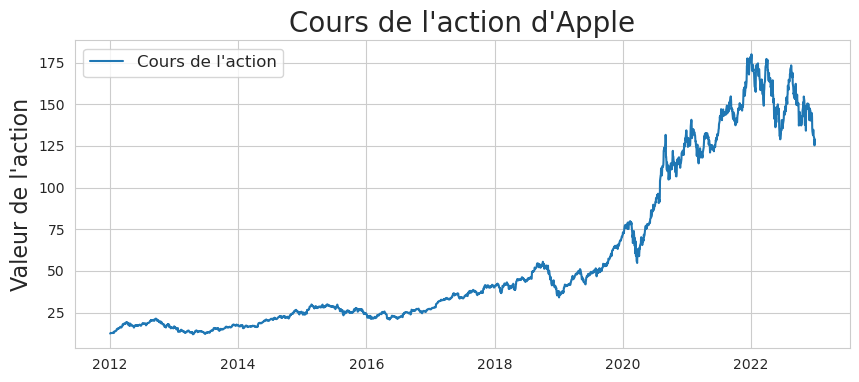

In [41]:
# Tracé du cours de l'action
plt.figure(figsize=(10,4))

plt.plot(action_df['Adj Close'], label='Cours de l\'action')
plt.ylabel('Valeur de l\'action', fontsize=16)
plt.legend(fontsize=12)
plt.title('Cours de l\'action d\'Apple', fontsize=20)

plt.show()

### Regardons les rendements quotidiens de cette action

Rendement d'une action : 
- $Rendement=100\times\frac{action[Adj\_Close](t+1)-action[Adj\_Close](t)}{action[Adj\_Close](t)}$ 

In [42]:
#Calcul des rendements en prenant les valeurs ajustés de l'action au moment de la fermeture du marche
rendements = 100*action_df['Adj Close'].pct_change().dropna()
rendements

Date
2012-01-04    0.537388
2012-01-05    1.110228
2012-01-06    1.045371
2012-01-09   -0.158602
2012-01-10    0.358036
                ...   
2022-12-22   -2.377262
2022-12-23   -0.279821
2022-12-27   -1.387833
2022-12-28   -3.068527
2022-12-29    2.832440
Name: Adj Close, Length: 2766, dtype: float64

### Tracé des rendements et d'un QQplot

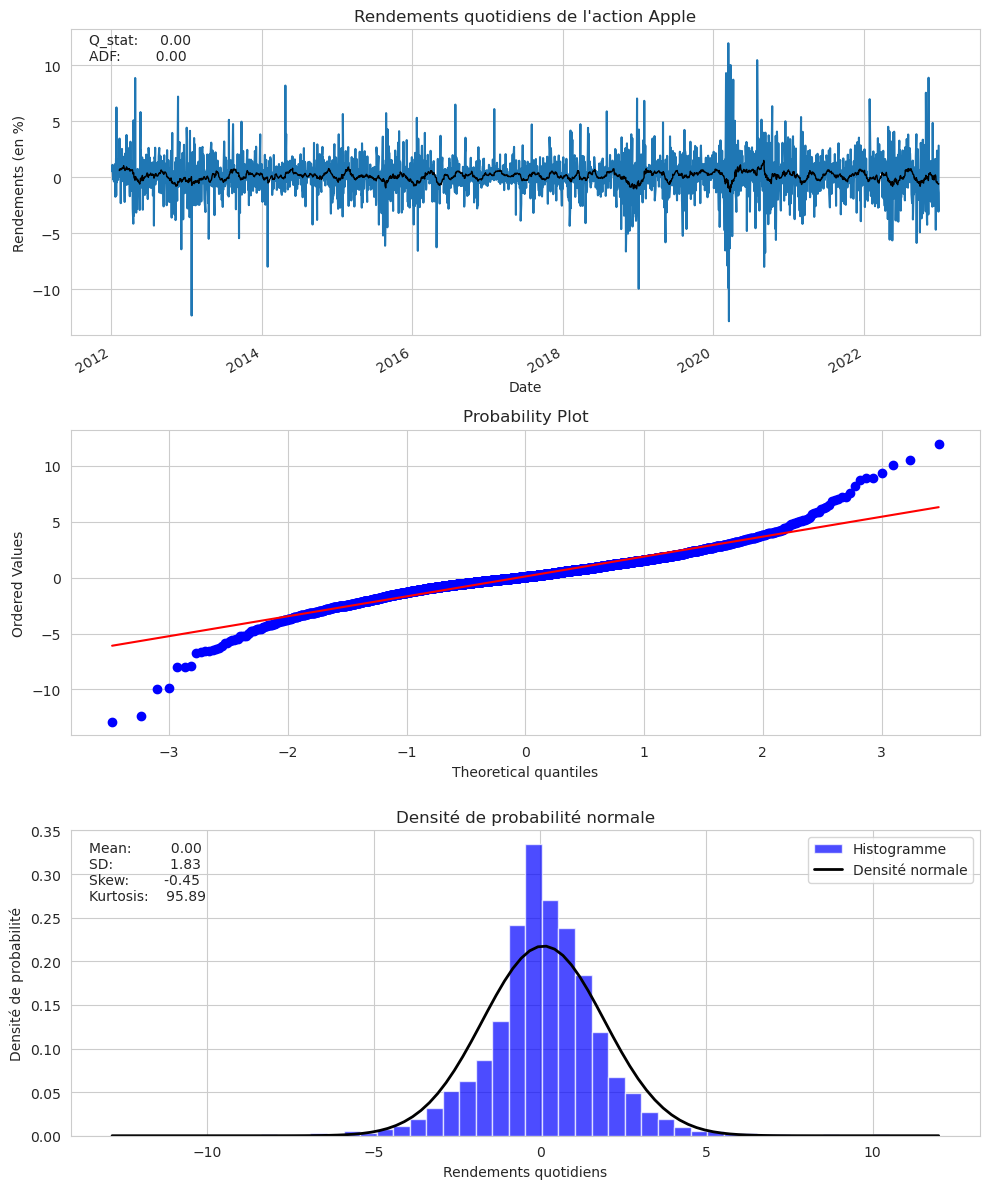

In [43]:
#Création d'un Subplot (3,1)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

#Graphe du rendements quotidiens sur le premier subplot
rendements.plot(ax=axes[0], title='Rendements quotidiens de l\'action Apple')
#On trace une moyenne glissante en noir pour mieux repérer les variations.
rendements.rolling(25).mean().plot(ax=axes[0], c='k', lw=1)
axes[0].set_ylabel('Rendements (en %)')
#Test de Ljung-Box et de Dickey-Fuller
q_p = np.max(q_stat(acf(rendements, nlags=120), len(rendements))[1])
#Mise en évidence de ces test sur le graphe
stats = f'Q_stat: {np.max(q_p):>8.2f}\nADF: {adfuller(rendements)[1]:>11.2f}'
axes[0].text(x=0.02, y=0.9, s=stats, transform=axes[0].transAxes)


#QQplot sur le deuxième subplot
probplot(rendements, plot=axes[1])


#Histogramme des rendements sur le troisième subplot
# Tracer l'histogramme sur le premier subplot
axes[2].hist(rendements, bins=50, density=True, color='blue', alpha=0.7, label='Histogramme')
axes[2].set_title('Histogramme des rendements')
axes[2].set_xlabel('Rendements quotidiens')
axes[2].set_ylabel('Densité de probabilité')
# Ajouter une ligne continue représentant une distribution normale
mu, std = rendements.mean(), rendements.std()
xmin, xmax = rendements.min(), rendements.max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[2].plot(x, p, 'k', linewidth=2, label='Densité normale')
axes[2].set_title('Densité de probabilité normale')
axes[2].set_xlabel('Rendements quotidiens')
axes[2].set_ylabel('Densité de probabilité')
axes[2].legend()
#Calcul les 4 premiers moments des rendements
mean, var, skew, kurtosis = moment(rendements, moment=[1,2,3,4])
#Mise en évidence dans la figure
s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
axes[2].text(x=0.02, y=0.77, s=s, transform=axes[2].transAxes)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

### Visualisation de l'autocorrélation partielle des rendements

L'autocorrélation mesure la corrélation d'une variable avec elle-même, lorsque les observations sont considérées avec un décalage dans le temps (autocorrélation temporelle) ou dans l'espace (autocorrélation spatiale). _Selon l'Insee_.  
  
  Cela nous permettra de déterminer l'ordre de notre modèle GARCH

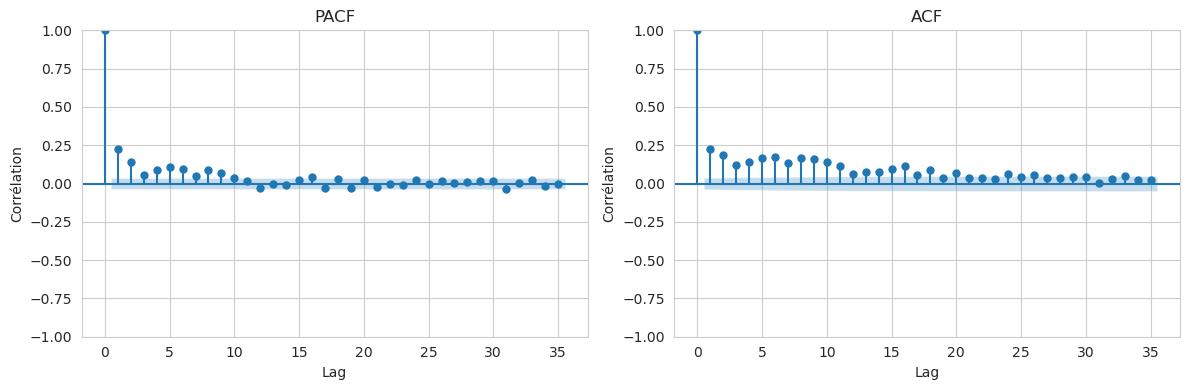

In [44]:
#On utilise les fonctions de la bibliothèque statsmodels.graphics.tsaplots pour l'ACF et le PACF

#Création d'un Subplot (1,2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracer la fonction d'autocorrélation partielle (PACF) sur le premier subplot
plot_pacf(rendements**2, ax=axes[0])
axes[0].set_title('PACF')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Corrélation')
axes[0].grid(True)

# Tracer la fonction d'autocorrélation (ACF) sur le deuxième subplot
plot_acf(rendements**2, ax=axes[1])
axes[1].set_title('ACF')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Corrélation')
axes[1].grid(True)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

## Etape 2 : Prédiction de volatilité

### D'abord nous allons chercher le meilleur modèle pour notre action

D'après le graphe de l'autocorrélation partiel, on remarque que notre graphe est cohérent jusqu'à la 3ème valeur, ainsi nous allons prendre p=q=3

In [45]:
# On utilise les fonctions de la bibliothèque arch
modele = arch_model(rendements, p=1, q=1)
# Estimation des paramètres du modèle
modele_fit = modele.fit()
modele_fit

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2622960297792.0747
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1523946.8814701801
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6804.10849585898
Iteration:      4,   Func. Count:     28,   Neg. LLF: 6934.99817515315
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5619.743235689465
Iteration:      6,   Func. Count:     41,   Neg. LLF: 5395.341810991257
Iteration:      7,   Func. Count:     47,   Neg. LLF: 5369.934754588688
Iteration:      8,   Func. Count:     52,   Neg. LLF: 5369.929208956887
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5369.926494026406
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5369.926439874131
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5369.926438597334
Iteration:     12,   Func. Count:     71,   Neg. LLF: 5369.926438597349
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5369.926438597334
            Iterations: 12
 

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5369.93
Distribution:                  Normal   AIC:                           10747.9
Method:            Maximum Likelihood   BIC:                           10771.6
                                        No. Observations:                 2766
Date:                Fri, Dec 29 2023   Df Residuals:                     2765
Time:                        17:04:16   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1782  3.261e-02      5.463  4.686e-08 [  0.114,  0.24

On remarque que de nombreux coefficients sont non significatifs à hauteur de 15%, le modèle n'est pas optimale. On va utiliser une autre méthode pour choisir p et q de sorte à ce qu'ils soient significatifs à 1%  

In [46]:
best_aic = float("inf")
best_order = None

for p in range(5):
    for q in range(5):
        try:
            modele = arch_model(rendements, vol='Garch', p=p, q=q)
            resultats = modele.fit(disp='off')
            aic = resultats.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except:
            continue

print(f"Meilleur ordre (p, q) : {best_order} avec AIC : {best_aic}")

Meilleur ordre (p, q) : (1, 1) avec AIC : 10747.852877194668


In [47]:
# On utilise les fonctions de la bibliothèque arch
modele = arch_model(rendements, p=1, q=1)
# Estimation des paramètres du modèle
modele_fit = modele.fit()
modele_fit

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2622960297792.0747
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1523946.8814701801
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6804.10849585898
Iteration:      4,   Func. Count:     28,   Neg. LLF: 6934.99817515315
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5619.743235689465
Iteration:      6,   Func. Count:     41,   Neg. LLF: 5395.341810991257
Iteration:      7,   Func. Count:     47,   Neg. LLF: 5369.934754588688
Iteration:      8,   Func. Count:     52,   Neg. LLF: 5369.929208956887
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5369.926494026406
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5369.926439874131
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5369.926438597334
Iteration:     12,   Func. Count:     71,   Neg. LLF: 5369.926438597349
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5369.926438597334
            Iterations: 12
 

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5369.93
Distribution:                  Normal   AIC:                           10747.9
Method:            Maximum Likelihood   BIC:                           10771.6
                                        No. Observations:                 2766
Date:                Fri, Dec 29 2023   Df Residuals:                     2765
Time:                        17:04:20   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1782  3.261e-02      5.463  4.686e-08 [  0.114,  0.24

In [48]:
rolling_predictions = []
taille_test = 1000

for i in range(taille_test):
    train = rendements[:-(taille_test-i)]
    modele = arch_model(train, p=1, q=1)
    modele_fit = modele.fit(disp='off')
    pred = modele_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [49]:
rolling_predictions = pd.Series(rolling_predictions, index=rendements.index[-1000:])

### Visualisation du modèle

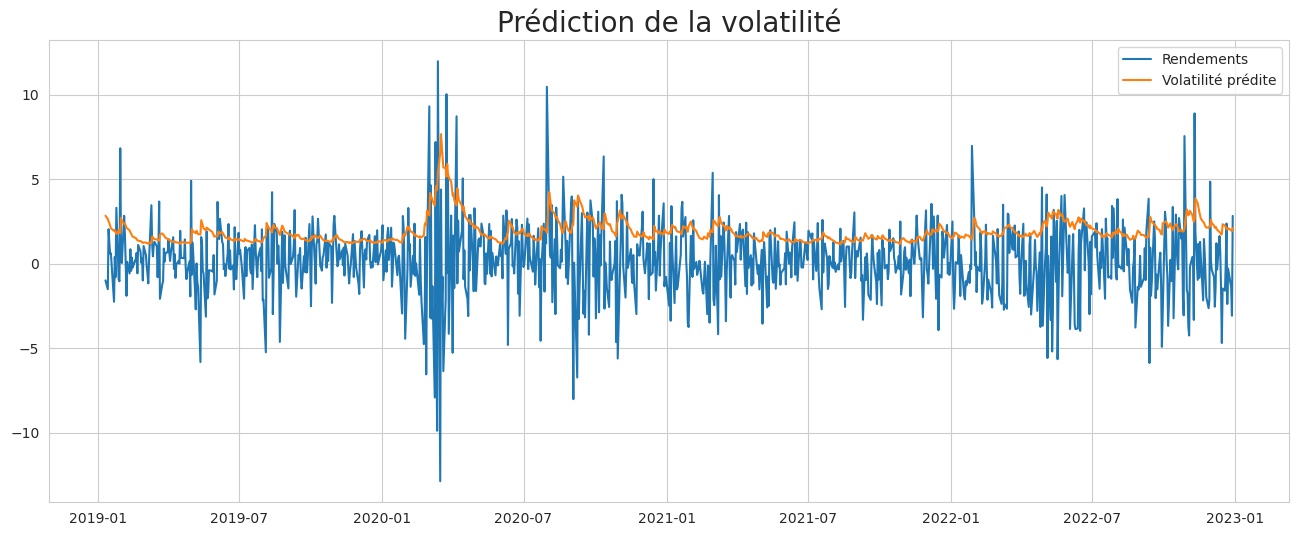

In [50]:
plt.figure(figsize=(16,6))
plt.plot(rendements[-1000:])
plt.plot(rolling_predictions)
plt.title('Prédiction de la volatilité', fontsize=20)
plt.legend(['Rendements', 'Volatilité prédite'], fontsize=10)

On voit bien dans ce graphe que la volatilité predite suit bien les variations des rendements de l'action, le modèle parait satisfaisant.

## Etape 3 : Utilisation du modèle 

### Nous allons maintenant utiliser le modèle pour trouver la volatilité à horizon d'un jour et d'une semaine

#### Horizon d'un jour :

In [51]:
donnes_entrainement = rendements
modele = arch_model(donnes_entrainement, p=1, q=1)
modele_fit = modele.fit(disp='off')
pred = modele_fit.forecast(horizon=3)
dates_futures = [rendements.index[-1] + timedelta(days=i) for i in range(1,4)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=dates_futures)

Text(0.5, 1.0, 'Prediction de la volatilité pour le prochain jour')

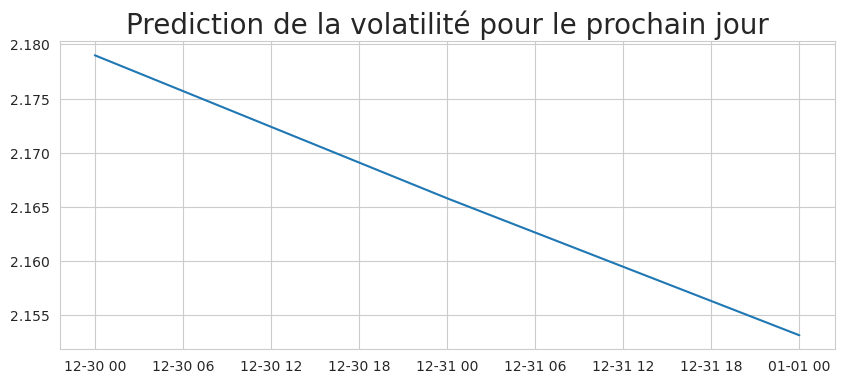

In [52]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Prediction de la volatilité pour le prochain jour', fontsize=20)

Regarder la volatilité a horizon d'un jour ne permet pas de se rendre compte précisemment des variations du cours de l'action

#### Horizon d'une semaine

In [53]:
pred_2 = modele_fit.forecast(horizon=7)
dates_futures_2 = [rendements.index[-1] + timedelta(days=i) for i in range(1,8)]
pred_2 = pd.Series(np.sqrt(pred_2.variance.values[-1,:]), index=dates_futures_2)

Text(0.5, 1.0, 'Prediction de la volatilité pour les 7 prochains jours')

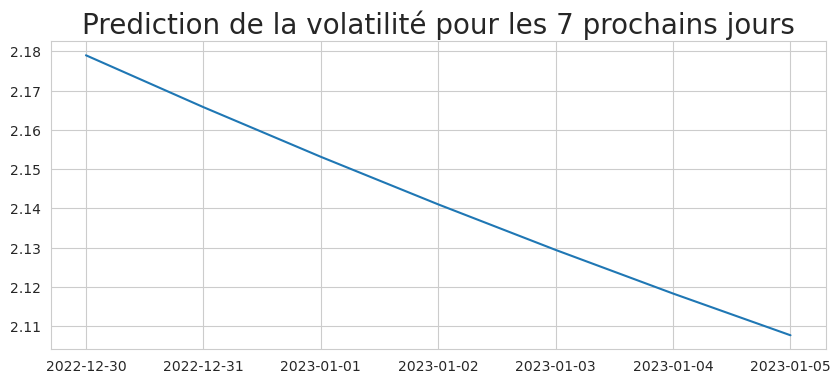

In [54]:
plt.figure(figsize=(10,4))
plt.plot(pred_2)
plt.title('Prediction de la volatilité pour les 7 prochains jours', fontsize=20)

## Etape 4 : Vérification de cette prédiction

### Nous allons voir si les prédictions sur 7 jours correspondent à la réalité

In [33]:
st_2 = datetime(2022,12,29)
ed_2 = datetime(2023,1,5)
action_df_verif = yf.download(tickers=action_nom, start=st_2, end=ed_2)
action_df_verif.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-29,127.989998,130.479996,127.730003,129.610001,128.889572,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.207779,77034200
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.374802,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.657639,89113600


In [35]:
#Calcul des rendements en prenant les valeurs ajustés de l'action au moment de la fermeture du marche
rendements_verif = 100*action_df_verif['Adj Close'].pct_change().dropna()
rendements_verif

Date
2022-12-30    0.246883
2023-01-03   -3.740469
2023-01-04    1.031428
Name: Adj Close, dtype: float64

Text(0.5, 1.0, "Cours de l'action d'Apple")

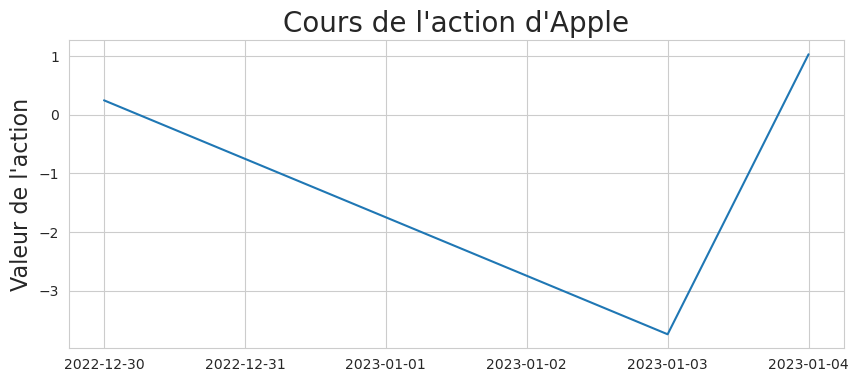

In [36]:
plt.figure(figsize=(10,4))
plt.plot(rendements_verif)
plt.ylabel('Valeur de l\'action', fontsize=16)
plt.title('Cours de l\'action d\'Apple', fontsize=20)

Ainsi on est censé s'attendre à une hausse de la volatilité puis une baisse

Text(0.5, 1.0, 'Prediction de la volatilité pour les 7 prochains jours')

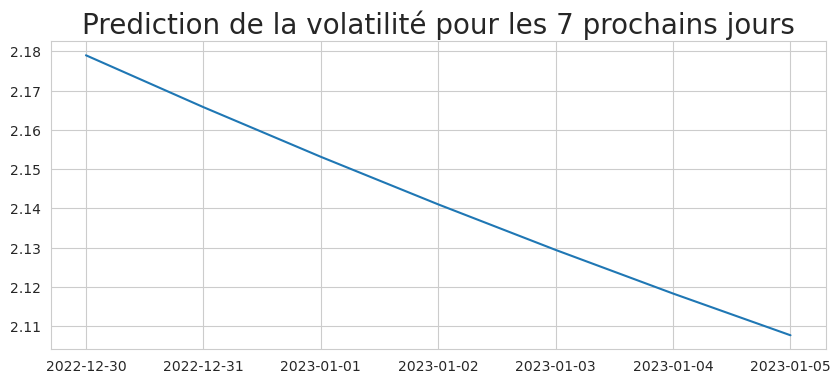

In [37]:
plt.figure(figsize=(10,4))
plt.plot(pred_2)
plt.title('Prediction de la volatilité pour les 7 prochains jours', fontsize=20)

On voit bien que du 27 au 31 janvier 2023, le cours d'Apple varie assez peu entre 142 et 145 alors que du 1 au 3 février 2023 l'action varie entre 145 et 154. La volatilité a augmenté entre ces 2 périodes ce qui se reflète bien dans nos prédictions. 

### Attention : Ce n'est pas parce que le modèle est vérifié pour cette semaine là que ce sera vrai dans tous les cas. Le modèle n'est pas synonyme de réalité !